In [ ]:
from helper import DataHelper

class DataHelperAugmented(DataHelper):

    def __init__(self,
                 data_pickle_path,
                 calc_weights=True,
                 theta=0.2,
                 focus_seq="MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW"
                 ):

        # Pass to the parents the only arguments that can be changed
        super().__init__(calc_weights=calc_weights, theta=theta) 

        # x_train = msa_3d for consistency with parent class
        self.x_train = self._unpickle_data(data_pickle_path)
        self.seq_len = self.x_train.shape[1]
        self.alphabet_size = 20

        # Generate the aa_dict to convert between letters and amino acid index
        self.aa_dict = self._generate_aa_dict()

        # The default focus_seq refers to BLAT_ECOLX
        self.focus_seq = focus_seq

        # Compute weights and Neff
        if calc_weights:
            self._compute_weights()
        else:
            self._isotropic_weights()
        self.n_eff = np.sum(self.weights)


    def _generate_aa_dict(self):
        aa_dict = {}
        for i, aa in enumerate("ACDEFGHIKLMNPQRSTVWY"):
            aa_dict[aa] = i
        return aa_dict

    
    def _unpickle_data(self, data_pickle_path):
        with open(data_pickle_path, 'rb') as pickleFile:
            return pickle.load(pickleFile)

    def _compute_weights(self):
        '''X = T.tensor3("x")
        cutoff = T.scalar("theta")
        X_flat = X.reshape((X.shape[0], X.shape[1]*X.shape[2]))
        N_list, updates = theano.map(lambda x: 1.0 / T.sum(T.dot(X_flat, x) / T.dot(x, x) > 1 - cutoff), X_flat)
        weightfun = theano.function(inputs=[X, cutoff], outputs=[N_list],allow_input_downcast=True)
        self.weights = weightfun(self.x_train, self.theta)[0]'''
        pass

    def _isotropic_weights(self):
        self.weights = np.ones(self.x_train.shape[0])

    def convert_aa_from_string_to_one_hot(self, mutant_sequences):

        mutant_sequences_one_hot = np.zeros((len(mutant_sequences),self.seq_len, self.alphabet_size))

        for i,sequence in enumerate(mutant_sequences):
            for j,letter in enumerate(sequence):
                k = self.aa_dict[letter]
                mutant_sequences_one_hot[i,j,k] = 1.0

        return mutant_sequences_one_hot

    
    def delta_elbo(self, model, representation_mutant, mutant_tuple_list, N_pred_iterations=10, method="mse"):
        '''
        Overwiritng method in DataHelper
        '''
        

        for pos, wt_aa, mut_aa in mutant_tuple_list:
            if pos not in range(1, self.seq_len+1):
                return f"Error: pos argument is out of index for the current focus sequence\nPlease enter a integer between 1 and {self.seq_len}"
            elif self.focus_seq[pos] != wt_aa:
                return f"Error: the amino acid for the focus sequence at position {pos} is {self.focus_seq[pos]}, not {wt_aa}"
            else:
                mutant_seq = list(self.focus_seq)
                mutant_seq[pos] = mut_aa
                mutant_seq = ''.join(mutant_seq)

        
        mutant_sequences = [self.focus_seq, mutant_seq]

        # This is the MSA one-hot stack of the focus sequence and the mutated sequence
        # It will serve as the groud truth in the MSE error
        sequences_one_hot_stack = self.convert_aa_from_string_to_one_hot(mutant_sequences)
        

        prediction_matrix = np.zeros((sequences_one_hot_stack.shape[0], N_pred_iterations))

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        sequences_one_hot_stack = sequences_one_hot_stack.to(device)
        
        for i in range(N_pred_iterations):

            if method == "mse":
                mse = nn.MSELoss(reduce=False)
                pred, mu, logvar = model(sequences_one_hot_stack)
                error = torch.mean(mse(sequences_one_hot_stack.view(-1, self.seq_len * self.alphabet_size), pred), dim=1)


            elif method == "log-likelihood":
                # TODO: implement method
                # logpx_i = logpxz + kl_latent
                #batch_preds, _, _ = model.all_likelihood_components(sequences_one_hot_stack)
                pass

            else:
                return "Error: the only accepted values for method are 'mse' or 'log-likelihood'"

            # TODO: make this a method of the model
            kl_latent = -0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1)

            prediction_matrix[:,i] = error.cpu().detach().numpy() + kl_latent.cpu().detach().numpy()


        # Then take the mean of all the elbo samples
        mean_elbos = np.mean(prediction_matrix, axis=1).flatten().tolist()

        wt_elbo = mean_elbos.pop(0)

        return mean_elbos[0] - wt_elbo

### Learn mapping from one-hot encoding to MSA representation

In [43]:
# TODO: need to run OpenFold to get more examples!!!
# Is this mapping effective? The train set contains MSA representation of only stable proteins, not random mutations...

inverse_mapping_data_helper = DataHelperAugmented(data_pickle_path=path_msa_3d, calc_weights=False)

# The input of the VAE is the MSA
inverse_mapping_data_helper.x_train_finetune = inverse_mapping_data_helper.x_train[sel_seq]

# The output of the VAE is the MSA representation from OpenFold
inverse_mapping_data_helper.x_train = res_3d_scaled

In [47]:
model_inverse_mapping = train(inverse_mapping_data_helper, 
                              copy.deepcopy(model),
                              finetune=True, 
                              kl_latent_scale=0.0001,
                              kl_weights_scale=0,  
                              lr=0.001,
                              num_updates=3000,
                              batch_size=100)

Using device: cuda:0
Epoch: 0
	MSE loss: 0.10525071620941162
	KL latent loss: 0.01269411202520132
	KL weights loss: 0
	Total loss:0.1052519828081131
Epoch: 100
	MSE loss: 0.034538984298706055
	KL latent loss: 22.57163429260254
	KL weights loss: 0
	Total loss:0.036796148866415024
Epoch: 200
	MSE loss: 0.026949787512421608
	KL latent loss: 28.33131217956543
	KL weights loss: 0
	Total loss:0.029782919213175774
Epoch: 300
	MSE loss: 0.024774683639407158
	KL latent loss: 26.67344093322754
	KL weights loss: 0
	Total loss:0.027442026883363724
Epoch: 400
	MSE loss: 0.020044703036546707
	KL latent loss: 32.325531005859375
	KL weights loss: 0
	Total loss:0.02327725663781166
Epoch: 500
	MSE loss: 0.016979461535811424
	KL latent loss: 33.4113655090332
	KL weights loss: 0
	Total loss:0.020320598036050797
Epoch: 600
	MSE loss: 0.01712130568921566
	KL latent loss: 32.139163970947266
	KL weights loss: 0
	Total loss:0.02033522166311741
Epoch: 700
	MSE loss: 0.016511114314198494
	KL latent loss: 32.3876

In [48]:
model_inverse_mapping2 = train(inverse_mapping_data_helper, 
                               copy.deepcopy(model_inverse_mapping),
                               finetune=True, 
                               kl_latent_scale=0.0001,
                               kl_weights_scale=0,  
                               lr=0.0001,
                               num_updates=1000,
                               batch_size=100)

Using device: cuda:0
Epoch: 0
	MSE loss: 0.008895603008568287
	KL latent loss: 25.774511337280273
	KL weights loss: 0
	Total loss:0.011473054066300392
Epoch: 100
	MSE loss: 0.008662426844239235
	KL latent loss: 25.729869842529297
	KL weights loss: 0
	Total loss:0.011235414072871208
Epoch: 200
	MSE loss: 0.008930609561502934
	KL latent loss: 26.10791778564453
	KL weights loss: 0
	Total loss:0.011541401036083698
Epoch: 300
	MSE loss: 0.008825181983411312
	KL latent loss: 26.015426635742188
	KL weights loss: 0
	Total loss:0.01142672449350357
Epoch: 400
	MSE loss: 0.008642734959721565
	KL latent loss: 25.89731788635254
	KL weights loss: 0
	Total loss:0.01123246643692255
Epoch: 500
	MSE loss: 0.007942761294543743
	KL latent loss: 25.951210021972656
	KL weights loss: 0
	Total loss:0.010537882335484028
Epoch: 600
	MSE loss: 0.00887771975249052
	KL latent loss: 25.768802642822266
	KL weights loss: 0
	Total loss:0.011454599909484386
Epoch: 700
	MSE loss: 0.008587897755205631
	KL latent loss: 26

In [49]:
torch.save(model_inverse_mapping2, "model_checkpoints/model_inverse_mapping2.pt")

In [24]:
model_inverse_mapping = torch.load("model_checkpoints/model_inverse_mapping2.pt")

## Delta elbo

To perform the delta_elbo method on a mutation, the input of the model in not the MSA representation, but the one-hot encoding. <br>
The MSA representation of the random mutation is obtained with the model_inverse_mapping

In [25]:
#baseline_data_helper.delta_elbo(baseline_data_helper,[(175,"A","C")], N_pred_iterations=500)

In [26]:
#!pip install pandas
#!pip install seaborn
#!pip install tqdm

In [27]:
import pandas as pd
import seaborn as sns

In [28]:
df_mutations = pd.read_csv("blat_ecolx_mutation_fitness.csv")
df_mutations.head()

,mutant,0,39,156,625,2500,cefotaxime,0_1,0_2,10_1,...,km,vmax,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent
0,H24C,0.022702,0.045890,-0.025738,0.018871,-0.418260,-0.031941,-0.037095,0.082499,0.002591,...,0.785765,1.519964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,H24E,0.011387,-0.012636,-0.018955,-0.020436,-0.279024,0.016456,0.013497,0.009277,0.054104,...,0.757583,1.502589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,H24D,0.042301,0.017005,0.018951,0.006743,-0.181607,-0.030326,0.033849,0.050753,0.002764,...,0.763290,1.622028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,H24G,0.011460,-0.024511,-0.023807,-0.017209,-0.060242,-0.009657,-0.000472,0.023393,-0.013742,...,1.099628,1.736941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,H24F,0.020599,0.020321,-0.015905,0.016190,-0.818487,-0.000809,0.021397,0.019801,-0.001591,...,1.074944,1.574923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

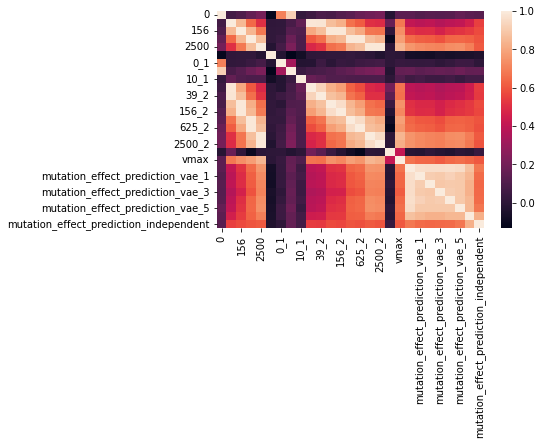

In [29]:
sns.heatmap(df_mutations.corr())

### Delta elbo from inverse function

In [30]:
def get_mutant_seq(pos, new_aa):
    mutant_seq = list(baseline_data_helper.focus_seq)
    mutant_seq[pos-1] = new_aa
    return "".join(mutant_seq)

In [31]:
focus_seq_msa_one_hot = finetune_data_helper.convert_aa_from_string_to_one_hot([finetune_data_helper.focus_seq])
focus_seq_msa_one_hot

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.]]])

In [32]:
# TODO: can it be extracted from the actual output of OpenFold?
# Is the first row always the same?

focus_seq_msa_representation, _, _ = model_inverse_mapping(torch.Tensor(focus_seq_msa_one_hot).to(torch.device("cuda:0")))
focus_seq_msa_representation = focus_seq_msa_representation.view(1, 286, 20)
focus_seq_msa_representation

tensor([[[0.9912, 0.1949, 0.4637,  ..., 0.3745, 0.0329, 0.5811],
         [0.9838, 0.4184, 0.6245,  ..., 0.4489, 0.0502, 0.2707],
         [0.9865, 0.0210, 0.3741,  ..., 0.4607, 0.0309, 0.1986],
         ...,
         [0.9495, 0.4050, 0.4383,  ..., 0.1788, 0.0731, 0.1023],
         [0.9461, 0.2902, 0.4557,  ..., 0.2756, 0.1966, 0.1541],
         [0.9631, 0.2474, 0.4993,  ..., 0.2088, 0.1102, 0.1816]]],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [33]:
mutant_seq = get_mutant_seq(pos=100, new_aa="D")
mutant_seq

'MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDDVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW'

In [34]:
mutant_seq_msa_one_hot = finetune_data_helper.convert_aa_from_string_to_one_hot([mutant_seq])
mutant_seq_msa_one_hot

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.]]])

In [35]:
mutant_seq_msa_one_hot.shape

(1, 286, 20)

In [36]:
mutant_seq_msa_representation, _, _ = model_inverse_mapping(torch.Tensor(mutant_seq_msa_one_hot).to(torch.device("cuda:0")))
mutant_seq_msa_representation = mutant_seq_msa_representation.view(1, 286, 20)
mutant_seq_msa_representation

tensor([[[0.9895, 0.2044, 0.4774,  ..., 0.4027, 0.0346, 0.6145],
         [0.9809, 0.4508, 0.6683,  ..., 0.4870, 0.0531, 0.2891],
         [0.9849, 0.0212, 0.3904,  ..., 0.5005, 0.0329, 0.2095],
         ...,
         [0.9533, 0.4212, 0.4866,  ..., 0.1685, 0.0644, 0.0919],
         [0.9384, 0.2976, 0.5032,  ..., 0.2763, 0.1922, 0.1479],
         [0.9668, 0.2525, 0.5611,  ..., 0.2085, 0.1067, 0.1711]]],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [37]:
mutant_seq_msa_representation.shape

torch.Size([1, 286, 20])

In [38]:
mutant_seq_msa_representation_stack = torch.stack([focus_seq_msa_representation, mutant_seq_msa_representation]).view(2, 286, 20)

In [85]:
mutant_seq_msa_representation_stack.shape

torch.Size([2, 286, 20])

In [41]:
finetune_data_helper.delta_elbo(model_finetune_scratch3, mutant_seq_msa_representation_stack, representation=True)

1.1059306144714345

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [43]:
from tqdm import tqdm

In [44]:
mutation_score = []

for mutation_string in tqdm(df_mutations.mutant):

    pos = int(mutation_string[1:3])
    new_aa = mutation_string[-1]

    mutant_seq = get_mutant_seq(pos=pos, new_aa=new_aa)
    mutant_seq_msa_one_hot = finetune_data_helper.convert_aa_from_string_to_one_hot([mutant_seq])
    mutant_seq_msa_representation, _, _ = model_inverse_mapping(torch.Tensor(mutant_seq_msa_one_hot).to(device))
    mutant_seq_msa_representation = mutant_seq_msa_representation.view(1, 286, 20)

    mutant_seq_msa_representation_stack = torch.stack([focus_seq_msa_representation, mutant_seq_msa_representation]).view(2, 286, 20)
    delta_elbo = finetune_data_helper.delta_elbo(model_finetune_scratch3, mutant_seq_msa_representation_stack, representation=True)

    mutation_score.append(delta_elbo)
    

100%|██████████| 4996/4996 [01:06<00:00, 75.43it/s]


In [49]:
mutation_score

[-0.4742165565490719,
 0.5699098587036122,
 0.41790771484375,
 1.173817443847657,
 -3.1736372947692875,
 -0.5995581626892079,
 -0.08205556869506836,
 -0.0779409408569336,
 -0.30003185272216726,
 -1.214982795715331,
 -2.0484160423278794,
 -1.4267603874206554,
 -1.7607841491699219,
 0.6723456382751465,
 0.12058334350585831,
 0.7416707038879391,
 0.4216771125793457,
 -0.38905639648437607,
 0.7887452125549306,
 -0.12941188812255788,
 -0.6412184715271003,
 -1.7324022293090806,
 0.3057733535766598,
 -1.0552699089050304,
 -1.2320208549499512,
 0.16068038940429652,
 0.8119416236877441,
 -1.204882717132568,
 -1.4335642814636227,
 0.019317722320556285,
 -0.09596414566039968,
 -1.1248194694519036,
 -0.3848979949951161,
 -1.2115722656249996,
 0.011337661743164418,
 0.7009470939636238,
 -0.3836806297302253,
 -2.039724731445313,
 0.7578387260437012,
 -0.5336370468139648,
 -0.8394169807434082,
 0.4560601234436046,
 -0.4616850852966312,
 0.09202079772949112,
 -0.04291200637817383,
 0.13733377456665075

In [45]:
df_mutations['msa_representation'] = pd.Series(mutation_score)

In [46]:
df_mutations.head()

,mutant,0,39,156,625,2500,cefotaxime,0_1,0_2,10_1,...,vmax,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,msa_representation
0,H24C,0.022702,0.045890,-0.025738,0.018871,-0.418260,-0.031941,-0.037095,0.082499,0.002591,...,1.519964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.474217
1,H24E,0.011387,-0.012636,-0.018955,-0.020436,-0.279024,0.016456,0.013497,0.009277,0.054104,...,1.502589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.569910
2,H24D,0.042301,0.017005,0.018951,0.006743,-0.181607,-0.030326,0.033849,0.050753,0.002764,...,1.622028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.417908
3,H24G,0.011460,-0.024511,-0.023807,-0.017209,-0.060242,-0.009657,-0.000472,0.023393,-0.013742,...,1.736941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.173817
4,H24F,0.020599,0.020321,-0.015905,0.016190,-0.818487,-0.000809,0.021397,0.019801,-0.001591,...,1.574923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.173637


<AxesSubplot:>

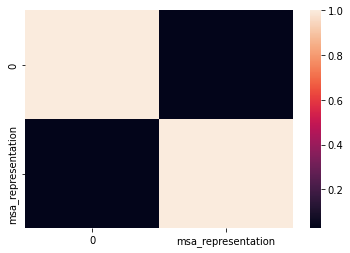

In [47]:
sns.heatmap(df_mutations[['0', 'msa_representation']].corr())

<AxesSubplot:>

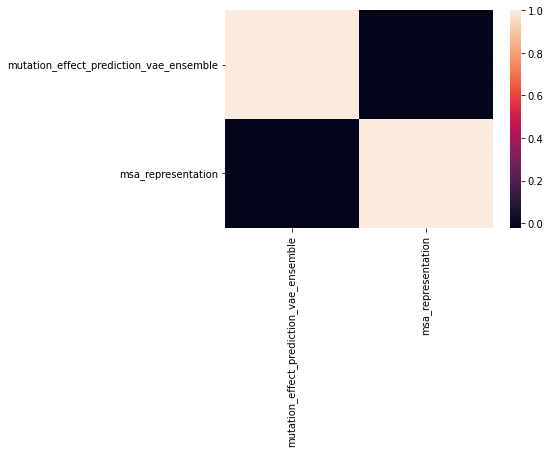

In [48]:
sns.heatmap(df_mutations[['mutation_effect_prediction_vae_ensemble', 'msa_representation']].corr())

### Select 10 high and 10 lows based on best model DeepSequence

In [55]:
# Lowest value mutations

lowest_mutations = df_mutations.sort_values(by='mutation_effect_prediction_vae_ensemble', ascending=True).head(10)


low_mutation_sequences = list()

for mutation_string in lowest_mutations['mutant']:
    pos = int(mutation_string[1:3])
    new_aa = mutation_string[-1]

    mutant_seq = get_mutant_seq(pos=pos, new_aa=new_aa)

    low_mutation_sequences.append(mutant_seq)

low_mutation_sequences

['MSIQHFRVALIPFFAAFCLPVFYHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW',
 'MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW',
 'MSIQHFRVALIPFFAAYCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW',
 'MSIQHFRVALIPFFAAKCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAI

In [54]:
# Lowest value mutations

highest_mutations = df_mutations.sort_values(by='mutation_effect_prediction_vae_ensemble', ascending=False).head(10)

high_mutation_sequences = list()

for mutation_string in highest_mutations['mutant']:
    pos = int(mutation_string[1:3])
    new_aa = mutation_string[-1]

    mutant_seq = get_mutant_seq(pos=pos, new_aa=new_aa)

    high_mutation_sequences.append(mutant_seq)

high_mutation_sequences

['MSIQHFRVALIPFFAAFTLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW',
 'MSIQHFRVALIPFFRAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW',
 'MSIQHFRVALIPFFAAFCLPVFAHPLTLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW',
 'MSIQHFRVALIPFFAAGCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAI

In [306]:
sequences_openfold_dict = dict()

for i, seq in enumerate(low_mutation_sequences):

    dict_string = f"low_{i+1}"
    sequences_openfold_dict[dict_string] = seq

for i, seq in enumerate(high_mutation_sequences):

    dict_string = f"high_{i+1}"
    sequences_openfold_dict[dict_string] = seq

In [307]:
sequences_openfold_dict

{'low_1': 'MSIQHFRVALIPFFAAFCLPVFYHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW',
 'low_2': 'MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW',
 'low_3': 'MSIQHFRVALIPFFAAYCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW',
 'low_4': 'MSIQHFRVALIPFFAAKCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQL

In [308]:
filepath = "sequences_openfold_dict.pickle"
output_dir = "./data_pickle"
output_path = os.path.join(output_dir, filepath)
with open(output_path, 'wb') as f:
    pickle.dump(sequences_openfold_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

### Delta elbo from MSA representation

In [50]:
df_mutations.sort_values(by='mutation_effect_prediction_vae_ensemble', ascending=False).head(10)

,mutant,0,39,156,625,2500,cefotaxime,0_1,0_2,10_1,...,vmax,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,msa_representation
2978,M180T,0.054493,-0.065005,-0.001646,-0.024703,0.023799,-0.027054,-0.089290,0.198277,0.040511,...,3.610470,6.016223,7.249511,5.492691,5.487994,6.123115,5.727808,0.436439,5.898483,0.442465
2426,H151R,-0.031583,0.013202,-0.033824,0.007599,0.023081,0.026863,0.005309,-0.068474,-0.039749,...,2.649198,4.344642,4.331342,4.692338,5.363595,3.473278,3.862659,-0.198879,2.545080,-0.078796
4512,T261L,-0.031352,-0.006617,-0.044324,0.002888,0.020071,0.162113,-0.036644,-0.026059,-0.015112,...,2.720637,3.645090,3.570366,2.109858,4.089371,6.755316,1.700540,0.046951,-0.951934,-0.633313
2834,N173G,0.009625,-0.013040,-0.003237,-0.002602,-0.001622,-0.053431,-0.010172,0.029421,0.029020,...,2.549827,3.432092,3.834843,3.617056,2.999996,3.084716,3.623848,0.062597,2.160866,-0.681161
2976,M180S,-0.012612,-0.039474,0.041602,0.069146,-0.033145,-0.056212,-0.069623,0.044398,-0.010363,...,2.724819,3.373193,4.326896,3.789995,1.311934,4.098695,3.338446,-1.593435,4.733809,1.052043
398,I45A,-0.014891,-0.010251,-0.003677,0.060312,-0.090534,-0.056742,-0.034279,0.004497,-0.204930,...,2.830663,3.326653,3.298470,3.066869,3.282030,2.522153,4.463745,0.169602,3.435508,1.025141
4508,T261I,-0.030540,0.000023,-0.038620,0.008888,0.027492,0.088768,-0.035476,-0.025604,0.051343,...,2.630264,3.277042,3.323407,2.516452,3.247402,5.873855,1.424091,-0.522039,-1.292593,-0.316269
663,F58Y,-0.022005,-0.004815,-0.027551,0.088074,-0.020413,0.106657,-0.003328,-0.040683,-0.165577,...,2.328097,2.810577,1.907714,3.848563,3.197074,2.733170,2.366366,1.631268,1.278646,0.267540
2465,M153T,-0.003635,-0.029682,-0.033427,-0.012526,-0.079236,0.042771,0.019114,-0.026384,0.014958,...,2.176297,2.763944,3.307745,1.596822,3.209588,3.241734,2.463830,-0.947933,-0.601092,-0.127289
2301,E145G,0.000819,0.031151,0.018635,0.013202,-0.009259,-0.103088,-0.013126,0.014764,0.025351,...,2.548145,2.634118,2.341690,2.476276,3.353486,2.092528,2.906608,-1.556128,1.154514,-1.521099


In [58]:
df_low_and_high = pd.concat([lowest_mutations, highest_mutations]).reset_index(drop=True)
df_low_and_high

,mutant,0,39,156,625,2500,cefotaxime,0_1,0_2,10_1,...,vmax,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,msa_representation
0,D231Y,-0.035409,-0.068099,-0.044574,-1.340158,-2.292514,-0.004309,-0.026290,-0.044527,0.061275,...,0.724427,-19.444442,-22.947963,-16.732115,-18.123891,-20.668520,-18.749722,-10.531550,-8.194206,-0.172887
1,D177F,-0.040113,-1.458631,-2.239600,-2.703805,-2.845423,0.086759,-0.031420,-0.048805,0.046117,...,-1.032468,-19.301670,-18.542238,-20.157163,-17.198591,-19.466376,-21.143984,-9.564736,-7.424561,-1.123331
2,D177Y,-0.026625,-1.440494,-1.573095,-2.651457,-2.381121,0.265678,-0.035415,-0.017835,0.035992,...,1.881614,-19.241816,-18.293330,-20.331692,-16.844289,-19.514616,-21.225151,-10.196314,-9.092939,0.532550
3,D177K,-0.076135,-1.651552,-2.235123,-2.670331,-2.962464,-0.027912,-0.058461,-0.093808,-0.012706,...,-0.931413,-19.104343,-17.078636,-20.782902,-18.443970,-17.882252,-21.333952,-10.223511,-9.090818,0.243597
4,D177W,-0.004004,-1.293930,-2.227542,-2.512236,-3.193444,-0.082694,-0.018163,0.010156,0.092010,...,-0.898744,-19.057361,-18.108899,-18.691109,-17.705571,-19.228125,-21.553099,-10.388299,-9.900580,0.144086
5,D177M,-0.037824,-1.631384,-1.881562,-2.607206,-2.748824,0.285961,-0.019710,-0.055939,-0.055308,...,-1.116083,-18.964386,-18.420309,-19.450639,-18.546619,-17.263639,-21.140722,-8.807472,-6.756386,-2.164147
6,L197D,-0.080198,0.048741,-0.032297,-2.055622,-2.265152,-0.049183,-0.029964,-0.130431,-0.012700,...,0.431602,-18.962847,-18.902239,-21.190705,-19.861436,-17.282584,-17.577269,-10.118896,-7.750219,-0.116123
7,T69F,-0.071454,-0.801646,-1.826177,-2.111818,-3.335355,0.029183,-0.041299,-0.101609,-0.075967,...,1.230137,-18.881075,-20.956542,-19.765423,-15.747919,-20.227852,-17.707638,-11.194624,-10.075813,-0.553830
8,D177I,-0.039548,-1.407182,-2.173694,-1.885324,-2.978487,-0.029233,-0.032159,-0.046936,0.033558,...,-0.764645,-18.842727,-18.468567,-18.724853,-17.707164,-17.286759,-22.026291,-8.346648,-6.332586,0.553254
9,D177L,0.007256,-1.478178,-2.121342,-2.519836,-3.036516,0.004880,0.007512,0.007001,0.002233,...,-0.971962,-18.686233,-17.798181,-20.193497,-17.641533,-16.671842,-21.126112,-8.152707,-6.072713,0.671252


In [98]:
df_low_and_high['name'] = [f'low_{i+1}' for i in range(10)] + [f'high_{i+1}' for i in range(10)]

In [99]:
df_low_and_high.head()

,mutant,0,39,156,625,2500,cefotaxime,0_1,0_2,10_1,...,mutation_effect_prediction_vae_ensemble,mutation_effect_prediction_vae_1,mutation_effect_prediction_vae_2,mutation_effect_prediction_vae_3,mutation_effect_prediction_vae_4,mutation_effect_prediction_vae_5,mutation_effect_prediction_pairwise,mutation_effect_prediction_independent,msa_representation,name
0,D231Y,-0.035409,-0.068099,-0.044574,-1.340158,-2.292514,-0.004309,-0.026290,-0.044527,0.061275,...,-19.444442,-22.947963,-16.732115,-18.123891,-20.668520,-18.749722,-10.531550,-8.194206,-0.172887,low_1
1,D177F,-0.040113,-1.458631,-2.239600,-2.703805,-2.845423,0.086759,-0.031420,-0.048805,0.046117,...,-19.301670,-18.542238,-20.157163,-17.198591,-19.466376,-21.143984,-9.564736,-7.424561,-1.123331,low_2
2,D177Y,-0.026625,-1.440494,-1.573095,-2.651457,-2.381121,0.265678,-0.035415,-0.017835,0.035992,...,-19.241816,-18.293330,-20.331692,-16.844289,-19.514616,-21.225151,-10.196314,-9.092939,0.532550,low_3
3,D177K,-0.076135,-1.651552,-2.235123,-2.670331,-2.962464,-0.027912,-0.058461,-0.093808,-0.012706,...,-19.104343,-17.078636,-20.782902,-18.443970,-17.882252,-21.333952,-10.223511,-9.090818,0.243597,low_4
4,D177W,-0.004004,-1.293930,-2.227542,-2.512236,-3.193444,-0.082694,-0.018163,0.010156,0.092010,...,-19.057361,-18.108899,-18.691109,-17.705571,-19.228125,-21.553099,-10.388299,-9.900580,0.144086,low_5


In [89]:
focus_seq_msa_representation = torch.Tensor(pca.transform(af_repr[0]))

In [90]:
focus_seq_msa_representation.shape

torch.Size([286, 20])

In [140]:
from helper import DataHelper

class DataHelperAugmented(DataHelper):

    def __init__(self,
                 data_pickle_path,
                 calc_weights=True,
                 theta=0.2,
                 focus_seq="MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW"
                 ):

        # Pass to the parents the only arguments that can be changed
        super().__init__(calc_weights=calc_weights, theta=theta) 

        # x_train = msa_3d for consistency with parent class
        self.x_train = self._unpickle_data(data_pickle_path)
        self.seq_len = self.x_train.shape[1]
        self.alphabet_size = 20

        # Generate the aa_dict to convert between letters and amino acid index
        self.aa_dict = self._generate_aa_dict()

        # The default focus_seq refers to BLAT_ECOLX
        self.focus_seq = focus_seq


        # Compute weights and Neff
        if calc_weights:
            self._compute_weights()
        else:
            self._isotropic_weights()
        self.n_eff = np.sum(self.weights)


    def _generate_aa_dict(self):
        aa_dict = {}
        for i, aa in enumerate("ACDEFGHIKLMNPQRSTVWY"):
            aa_dict[aa] = i
        return aa_dict

    
    def _unpickle_data(self, data_pickle_path):
        with open(data_pickle_path, 'rb') as pickleFile:
            return pickle.load(pickleFile)

    def _compute_weights(self):
        '''X = T.tensor3("x")
        cutoff = T.scalar("theta")
        X_flat = X.reshape((X.shape[0], X.shape[1]*X.shape[2]))
        N_list, updates = theano.map(lambda x: 1.0 / T.sum(T.dot(X_flat, x) / T.dot(x, x) > 1 - cutoff), X_flat)
        weightfun = theano.function(inputs=[X, cutoff], outputs=[N_list],allow_input_downcast=True)
        self.weights = weightfun(self.x_train, self.theta)[0]'''
        pass

    def _isotropic_weights(self):
        self.weights = np.ones(self.x_train.shape[0])

    def convert_aa_from_string_to_one_hot(self, mutant_sequences):

        mutant_sequences_one_hot = np.zeros((len(mutant_sequences),self.seq_len, self.alphabet_size))

        for i,sequence in enumerate(mutant_sequences):
            for j,letter in enumerate(sequence):
                k = self.aa_dict[letter]
                mutant_sequences_one_hot[i,j,k] = 1.0

        return mutant_sequences_one_hot

    
    def delta_elbo(self, model, representation_focus_20, representation_mutant_20, mutant_tuple_list, N_pred_iterations=10, method="mse"):
        '''
        Overwiritng method in DataHelper
        '''
        print(mutant_tuple_list)
        
        pos, wt_aa, mut_aa = mutant_tuple_list
        if pos not in range(1, self.seq_len+1):
            return f"Error: pos argument is out of index for the current focus sequence\nPlease enter a integer between 1 and {self.seq_len}"
        elif self.focus_seq[pos] != wt_aa:
            return f"Error: the amino acid for the focus sequence at position {pos} is {self.focus_seq[pos]}, not {wt_aa}"
        else:
            mutant_seq = list(self.focus_seq)
            mutant_seq[pos] = mut_aa
            mutant_seq = ''.join(mutant_seq)

        
        mutant_sequences = [self.focus_seq, mutant_seq]

        # This is the MSA one-hot stack of the focus sequence and the mutated sequence
        # It will serve as the groud truth in the MSE error
        sequences_one_hot_stack = torch.Tensor(self.convert_aa_from_string_to_one_hot(mutant_sequences))

        # This is the input to the model
        sequences_representation_20_stack = torch.stack([representation_focus_20, representation_mutant_20]).view(2, 286, 20)

        prediction_matrix = np.zeros((sequences_one_hot_stack.shape[0], N_pred_iterations))

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        sequences_one_hot_stack = sequences_one_hot_stack.to(device)
        sequences_representation_20_stack = sequences_representation_20_stack.to(device)
        
        for i in range(N_pred_iterations):

            if method == "mse":
                mse = nn.MSELoss(reduce=False)
                pred, mu, logvar = model(sequences_representation_20_stack)
                error = torch.mean(mse(sequences_one_hot_stack.view(-1, self.seq_len * self.alphabet_size), pred), dim=1)


            elif method == "log-likelihood":
                # TODO: implement method
                # logpx_i = logpxz + kl_latent
                #batch_preds, _, _ = model.all_likelihood_components(sequences_one_hot_stack)
                pass

            else:
                return "Error: the only accepted values for method are 'mse' or 'log-likelihood'"

            # TODO: make this a method of the model
            kl_latent = -0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1)

            prediction_matrix[:,i] = error.cpu().detach().numpy() + kl_latent.cpu().detach().numpy()


        # Then take the mean of all the elbo samples
        mean_elbos = np.mean(prediction_matrix, axis=1).flatten().tolist()

        wt_elbo = mean_elbos.pop(0)

        return mean_elbos[0] - wt_elbo

In [141]:
finetune_data_helper = DataHelperAugmented(data_pickle_path=path_msa_3d, calc_weights=False)

# x_train_finetune holds the MSA representation as the input for the finetune of the model
finetune_data_helper.x_train_finetune = res_3d_scaled

# x_train holds the output of the VAE, 
# therefore during finetuning the model learns to reconstruct the MSA one-hot from the MSA representation
# IMPORTANT: the MSA one-hot is sliced with sel_seq, which contains the indices sampled to obtain the MSA representation
finetune_data_helper.x_train = finetune_data_helper.x_train[sel_seq]

In [142]:
def get_tuple(name):

    mutation_string = df_low_and_high[df_low_and_high['name']==name]['mutant'].tolist()[0]
    return (int(mutation_string[1:4])-1, mutation_string[0], mutation_string[-1])

In [143]:
representation_folder = "data_pickle/low_and_high_representation/"

delta_elbo_low_and_high = []
mutation_representation_list = []

for msa_representation in os.listdir(representation_folder):

    representation_name = msa_representation.split(".")[0]

    print(representation_name)

    with open(os.path.join(representation_folder, msa_representation), 'rb') as f:
        representation_file = pickle.load(f)

    mutant_tuple_list = get_tuple(representation_name)
    
    # Shape (286, 20)
    mutation_representation = torch.Tensor(pca.transform(representation_file['msa'][0].cpu().numpy()))
    mutation_representation_list.append(mutation_representation.numpy())

    # model, representation_focus_20, representation_mutant_20, mutant_tuple_list
    d_elbo = finetune_data_helper.delta_elbo(model_finetune_scratch3, focus_seq_msa_representation, mutation_representation, mutant_tuple_list)
    print(f"\t{d_elbo}")
    delta_elbo_low_and_high.append(d_elbo)
    

low_3
(176, 'D', 'Y')
	6.24588074006485e+33
low_4


/home/elio/anaconda3/envs/deep_sequence_pytorch_env/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


(176, 'D', 'K')
	3.5729515557408385e+33
high_3


/home/elio/anaconda3/envs/deep_sequence_pytorch_env/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


(260, 'T', 'L')
	2.295383817857894e+33
low_2


/home/elio/anaconda3/envs/deep_sequence_pytorch_env/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


(176, 'D', 'F')
	1.6849758557544162e+33
high_2


/home/elio/anaconda3/envs/deep_sequence_pytorch_env/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


(150, 'H', 'R')
	5.131091904342608e+33
high_5


/home/elio/anaconda3/envs/deep_sequence_pytorch_env/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


(179, 'M', 'S')
	7.193512698677454e+33
high_1


/home/elio/anaconda3/envs/deep_sequence_pytorch_env/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


(179, 'M', 'T')
	3.0907729819841534e+33
low_1


/home/elio/anaconda3/envs/deep_sequence_pytorch_env/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


(230, 'D', 'Y')
	7.95999565340139e+33
high_4


/home/elio/anaconda3/envs/deep_sequence_pytorch_env/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


(172, 'N', 'G')
	5.0784191030960645e+33
low_5


/home/elio/anaconda3/envs/deep_sequence_pytorch_env/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


(176, 'D', 'W')
	3.1872400785154863e+33


/home/elio/anaconda3/envs/deep_sequence_pytorch_env/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [83]:
mutation_representation_list

[array([[111.696045 ,  -3.6859186,  34.49228  , ...,  19.520824 ,
         -31.045845 ,  42.582485 ],
        [166.16437  ,  27.153547 ,  85.32538  , ...,  32.95042  ,
         -41.598934 ,   0.8206504],
        [222.46906  , -18.997921 ,  78.21377  , ...,  82.29882  ,
         -29.195835 ,  22.611814 ],
        ...,
        [246.10286  ,  49.646877 ,  87.41967  , ...,   2.4145443,
         -32.623764 , -21.15739  ],
        [211.49165  ,  33.152298 ,  85.82205  , ...,  17.471142 ,
           4.9679675,  -8.478738 ],
        [227.88182  ,  24.410957 , 108.191086 , ...,  17.806395 ,
         -10.935854 ,   9.842696 ]], dtype=float32),
 array([[115.67952  ,  -2.0973175,  37.174862 , ...,  17.28086  ,
         -29.289383 ,  41.776573 ],
        [169.72708  ,  28.197983 ,  86.07518  , ...,  33.74487  ,
         -42.175167 ,   1.53773  ],
        [224.65688  , -17.427807 ,  79.613686 , ...,  83.818695 ,
         -25.347174 ,  19.571905 ],
        ...,
        [243.67642  ,  48.89783  ,  86.